<a href="https://colab.research.google.com/github/apester/PINN/blob/main/PINN_2D_AdvectionDiffusion_CN_ADI_withAccuracyViz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 2D Advection–Diffusion  
## ADI–Crank–Nicolson Ground Truth + PINN

We solve:

\[
c_t + u c_x + v c_y = D (c_{xx} + c_{yy}),
\quad (x,y)\in(0,L)^2, \quad t\in[0,T]
\]

### Parameters (close to 1D case)
- L = 2
- u = 1, v = 1
- D = 1/2
- IC: c(0,x,y) = x*y
- Dirichlet BC consistent with IC

Ground truth: IMEX scheme  
- Upwind explicit advection  
- ADI Crank–Nicolson diffusion  

PINN enforces:
- PDE residual
- Initial condition
- Boundary conditions


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from dataclasses import dataclass

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:

@dataclass
class Params:
    L: float = 2.0
    Nx: int = 80
    Ny: int = 80
    u: float = 1.0
    v: float = 1.0
    D: float = 0.5
    T: float = 1.0
    dt: float = 2e-3
    n_f: int = 40000
    n_ic: int = 10000
    n_bc: int = 16000
    epochs: int = 8000
    lr: float = 1e-3
    print_every: int = 400

p = Params()

dx = p.L / p.Nx
dy = p.L / p.Ny
Nt = int(p.T / p.dt)

print("dx=", dx, "dy=", dy, "Nt=", Nt)


dx= 0.025 dy= 0.025 Nt= 500


In [3]:

def ic_xy(x, y):
    return x * y

def bc_left(t, y):
    return 0*y

def bc_right(t, y):
    return p.L * y

def bc_bottom(t, x):
    return 0*x

def bc_top(t, x):
    return x * p.L


In [4]:

def thomas(a,b,c,d):
    n = len(b)
    cp = np.zeros(n-1)
    dp = np.zeros(n)

    cp[0] = c[0]/b[0]
    dp[0] = d[0]/b[0]

    for i in range(1,n-1):
        denom = b[i] - a[i-1]*cp[i-1]
        cp[i] = c[i]/denom
        dp[i] = (d[i]-a[i-1]*dp[i-1])/denom

    denom = b[-1] - a[-1]*cp[-1]
    dp[-1] = (d[-1]-a[-1]*dp[-2])/denom

    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in reversed(range(n-1)):
        x[i] = dp[i] - cp[i]*x[i+1]

    return x


In [5]:

def solve_2d():
    x = np.linspace(0,p.L,p.Nx+1)
    y = np.linspace(0,p.L,p.Ny+1)
    t = np.linspace(0,p.T,Nt+1)

    C = np.zeros((Nt+1,p.Ny+1,p.Nx+1))

    X,Y = np.meshgrid(x,y,indexing='xy')
    C[0] = ic_xy(X,Y)

    rx = p.D*p.dt/(2*dx*dx)
    ry = p.D*p.dt/(2*dy*dy)

    ax = -rx*np.ones(p.Nx-2)
    bx = (1+2*rx)*np.ones(p.Nx-1)
    cx = -rx*np.ones(p.Nx-2)

    ay = -ry*np.ones(p.Ny-2)
    by = (1+2*ry)*np.ones(p.Ny-1)
    cy = -ry*np.ones(p.Ny-2)

    for n in range(Nt):
        U = C[n].copy()

        # explicit advection
        A = np.zeros_like(U)
        A[:,1:-1] += p.u*(U[:,1:-1]-U[:,:-2])/dx
        A[1:-1,:] += p.v*(U[1:-1,:]-U[:-2,:])/dy

        Lap = np.zeros_like(U)
        Lap[1:-1,1:-1] = (
            (U[1:-1,2:]-2*U[1:-1,1:-1]+U[1:-1,:-2])/(dx*dx)
            +(U[2:,1:-1]-2*U[1:-1,1:-1]+U[:-2,1:-1])/(dy*dy)
        )

        RHS = U - p.dt*A + (p.D*p.dt/2)*Lap

        # x-sweep
        Ustar = U.copy()
        for j in range(1,p.Ny):
            d = RHS[j,1:-1]
            Ustar[j,1:-1] = thomas(ax,bx,cx,d)

        # y-sweep
        Un = Ustar.copy()
        for i in range(1,p.Nx):
            d = Ustar[1:-1,i]
            Un[1:-1,i] = thomas(ay,by,cy,d)

        C[n+1] = Un

    return x,y,t,C

x,y,t,C = solve_2d()
print("Ground truth shape:",C.shape)


Ground truth shape: (501, 81, 81)


In [6]:

class MLP(nn.Module):
    def __init__(self,width=128,depth=6):
        super().__init__()
        layers = [nn.Linear(3,width), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(width,width), nn.Tanh()]
        layers += [nn.Linear(width,1)]
        self.net = nn.Sequential(*layers)

    def forward(self,X):
        return self.net(X)

model = MLP().to(device)
model


MLP(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [7]:

def residual(X):
    X = X.clone().requires_grad_(True)
    c = model(X)
    grads = torch.autograd.grad(c,X,torch.ones_like(c),create_graph=True)[0]

    ct = grads[:,0:1]
    cx = grads[:,1:2]
    cy = grads[:,2:3]

    cxx = torch.autograd.grad(cx,X,torch.ones_like(cx),create_graph=True)[0][:,1:2]
    cyy = torch.autograd.grad(cy,X,torch.ones_like(cy),create_graph=True)[0][:,2:3]

    return ct + p.u*cx + p.v*cy - p.D*(cxx+cyy)


## PINN training + accuracy + visualization
The previous cells defined the PDE residual. The following cells:
1) sample IC/BC/collocation points,  
2) train the PINN,  
3) compute accuracy vs ADI-CN ground truth, and  
4) visualize GT vs PINN vs error as heatmaps.


In [8]:
# =========================
# 6) PINN datasets (IC/BC/collocation)
# =========================
def to_torch(a: np.ndarray) -> torch.Tensor:
    return torch.tensor(a, dtype=torch.float32, device=device).view(-1, 1)

def sample_ic(n: int, L: float):
    x_ = np.random.rand(n) * L
    y_ = np.random.rand(n) * L
    t_ = np.zeros(n)
    c_ = x_ * y_
    return x_, y_, t_, c_

def sample_bc(n: int, L: float, T: float):
    n_each = n // 4
    # x=0
    tL = np.random.rand(n_each) * T
    yL = np.random.rand(n_each) * L
    xL = np.zeros(n_each)
    cL = 0.0 * yL

    # x=L
    tR = np.random.rand(n_each) * T
    yR = np.random.rand(n_each) * L
    xR = np.ones(n_each) * L
    cR = L * yR

    # y=0
    tB = np.random.rand(n_each) * T
    xB = np.random.rand(n_each) * L
    yB = np.zeros(n_each)
    cB = 0.0 * xB

    # y=L
    tT = np.random.rand(n_each) * T
    xT = np.random.rand(n_each) * L
    yT = np.ones(n_each) * L
    cT = xT * L

    x = np.concatenate([xL, xR, xB, xT])
    y = np.concatenate([yL, yR, yB, yT])
    t_ = np.concatenate([tL, tR, tB, tT])
    c = np.concatenate([cL, cR, cB, cT])
    return x, y, t_, c

def sample_collocation(n: int, L: float, T: float):
    x_ = np.random.rand(n) * L
    y_ = np.random.rand(n) * L
    t_ = np.random.rand(n) * T
    return x_, y_, t_

x_ic, y_ic, t_ic, c_ic = sample_ic(p.n_ic, p.L)
x_bc, y_bc, t_bc, c_bc = sample_bc(p.n_bc, p.L, p.T)
x_f,  y_f,  t_f        = sample_collocation(p.n_f, p.L, p.T)

X_ic = torch.cat([to_torch(t_ic), to_torch(x_ic), to_torch(y_ic)], dim=1); Y_ic = to_torch(c_ic)
X_bc = torch.cat([to_torch(t_bc), to_torch(x_bc), to_torch(y_bc)], dim=1); Y_bc = to_torch(c_bc)
X_f  = torch.cat([to_torch(t_f),  to_torch(x_f),  to_torch(y_f )], dim=1)

print('IC', X_ic.shape, 'BC', X_bc.shape, 'F', X_f.shape)


IC torch.Size([10000, 3]) BC torch.Size([16000, 3]) F torch.Size([40000, 3])


In [9]:
# =========================
# 7) Train PINN
# =========================
w_f = 1.0
w_ic = 10.0
w_bc = 10.0

opt = torch.optim.Adam(model.parameters(), lr=p.lr)
loss_hist = []

for epoch in range(1, p.epochs + 1):
    opt.zero_grad()

    loss_ic = ((model(X_ic) - Y_ic)**2).mean()
    loss_bc = ((model(X_bc) - Y_bc)**2).mean()

    r = residual(X_f)
    loss_f = (r**2).mean()

    loss = w_f*loss_f + w_ic*loss_ic + w_bc*loss_bc
    loss.backward()
    opt.step()

    loss_hist.append([loss.item(), loss_f.item(), loss_ic.item(), loss_bc.item()])

    if epoch % p.print_every == 0 or epoch == 1:
        print(f'Epoch {epoch:5d} | total {loss.item():.3e} | f {loss_f.item():.3e} | ic {loss_ic.item():.3e} | bc {loss_bc.item():.3e}')


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch     1 | total 4.190e+01 | f 9.260e-05 | ic 1.656e+00 | bc 2.534e+00
Epoch   400 | total 2.624e-01 | f 1.090e-01 | ic 7.334e-03 | bc 8.001e-03
Epoch   800 | total 4.477e-02 | f 1.351e-02 | ic 1.083e-03 | bc 2.042e-03
Epoch  1200 | total 2.685e-02 | f 4.564e-03 | ic 7.247e-04 | bc 1.504e-03
Epoch  1600 | total 2.306e-02 | f 3.513e-03 | ic 6.451e-04 | bc 1.310e-03
Epoch  2000 | total 2.060e-02 | f 3.086e-03 | ic 5.826e-04 | bc 1.168e-03
Epoch  2400 | total 1.848e-02 | f 2.842e-03 | ic 5.248e-04 | bc 1.039e-03
Epoch  2800 | total 1.655e-02 | f 2.727e-03 | ic 4.661e-04 | bc 9.161e-04
Epoch  3200 | total 1.483e-02 | f 2.718e-03 | ic 4.079e-04 | bc 8.032e-04
Epoch  3600 | total 1.296e-02 | f 2.644e-03 | ic 3.477e-04 | bc 6.841e-04
Epoch  4000 | total 1.090e-02 | f 2.474e-03 | ic 2.799e-04 | bc 5.627e-04
Epoch  4400 | total 8.786e-03 | f 2.222e-03 | ic 2.102e-04 | bc 4.462e-04
Epoch  4800 | total 7.263e-03 | f 2.130e-03 | ic 1.586e-04 | bc 3.547e-04
Epoch  5200 | total 5.242e-03 | f 1.63

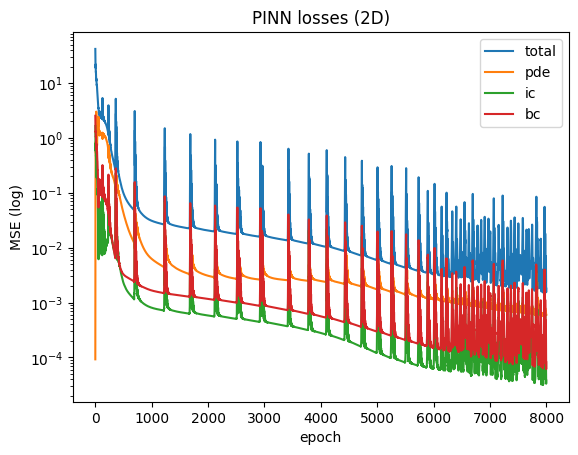

Accuracy vs ground truth:
  t=0.000 | relL2=5.960e-03 | MAE=5.626e-03
  t=0.500 | relL2=6.888e-01 | MAE=2.477e-01
  t=1.000 | relL2=7.654e-01 | MAE=2.588e-01


In [10]:
# =========================
# 8) Accuracy vs Ground Truth (ADI-CN) + training curves
# =========================
loss_hist = np.array(loss_hist)

plt.figure()
plt.semilogy(loss_hist[:,0], label='total')
plt.semilogy(loss_hist[:,1], label='pde')
plt.semilogy(loss_hist[:,2], label='ic')
plt.semilogy(loss_hist[:,3], label='bc')
plt.xlabel('epoch'); plt.ylabel('MSE (log)')
plt.title('PINN losses (2D)')
plt.legend(); plt.show()

@torch.no_grad()
def predict_on_grid(tval: float) -> np.ndarray:
    Xg, Yg = np.meshgrid(x, y, indexing='xy')
    tcol = np.full_like(Xg.ravel(), tval, dtype=np.float32)
    inp = np.column_stack([tcol, Xg.ravel().astype(np.float32), Yg.ravel().astype(np.float32)])
    inp_t = torch.tensor(inp, device=device)
    pred = model(inp_t).detach().cpu().numpy().reshape(y.size, x.size)
    return pred

def rel_l2(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm((a-b).ravel()) / (np.linalg.norm(b.ravel()) + 1e-12))

def mae(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.mean(np.abs(a-b)))

# evaluate at a few times
times_eval = [0.0, 0.5*p.T, p.T]
metrics = []
for tt in times_eval:
    idx = int(round(tt / p.dt))
    gt = C[idx]
    pred = predict_on_grid(t[idx])
    metrics.append([t[idx], rel_l2(pred, gt), mae(pred, gt)])

print('Accuracy vs ground truth:')
for tt, rl2, m in metrics:
    print(f'  t={tt:.3f} | relL2={rl2:.3e} | MAE={m:.3e}')


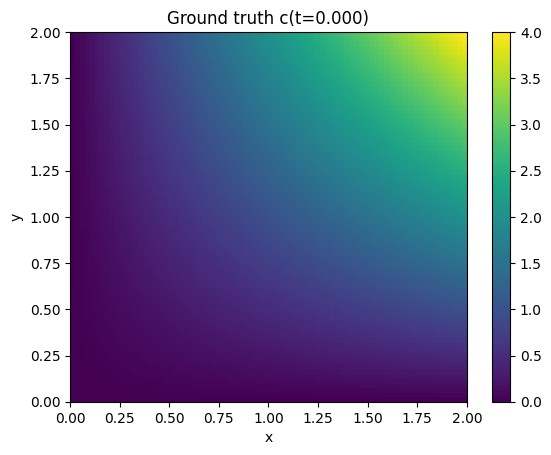

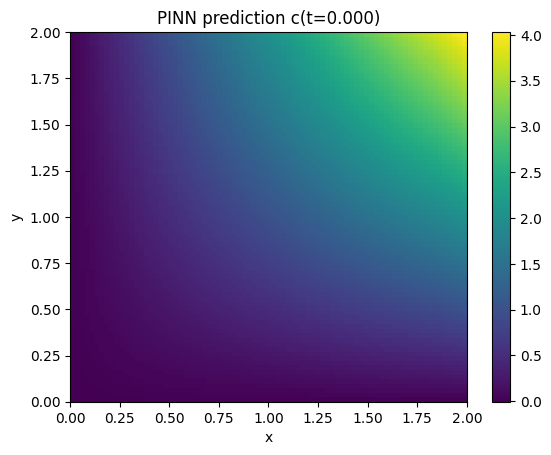

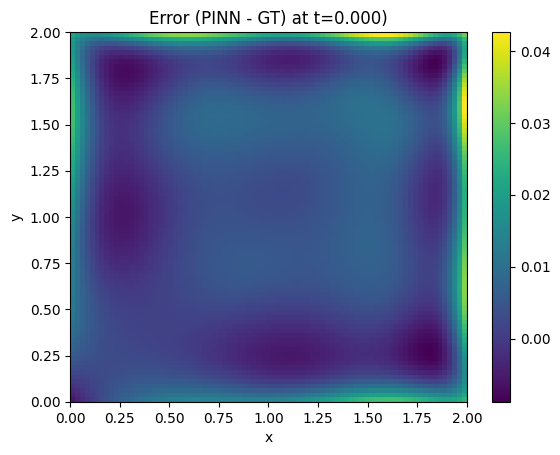

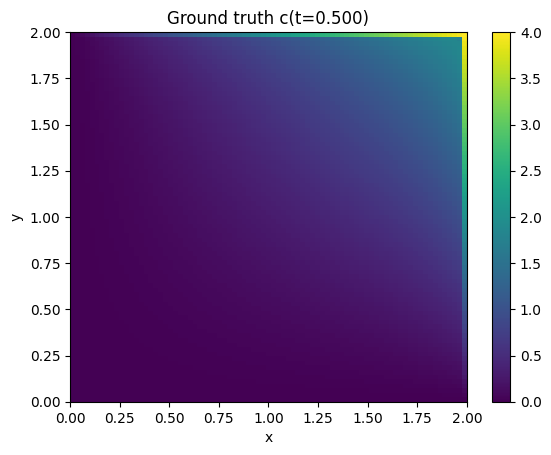

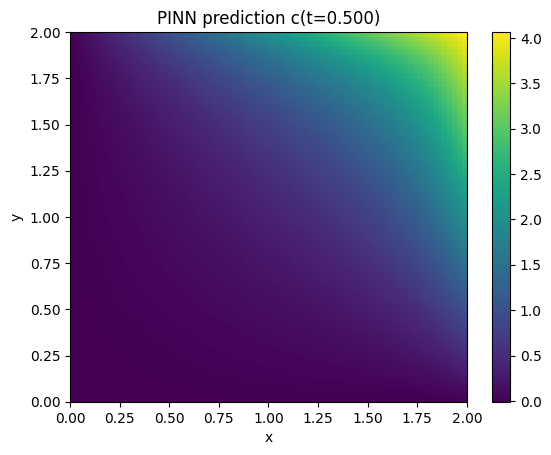

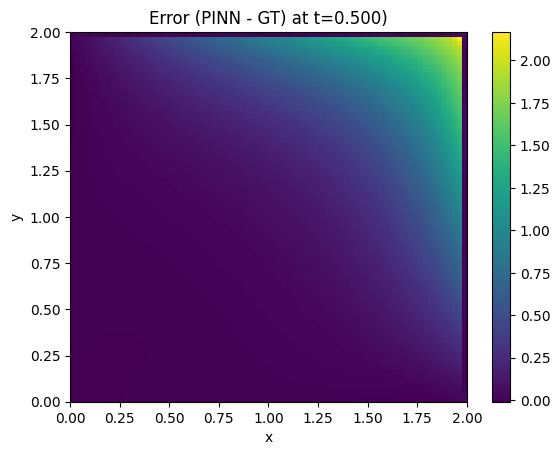

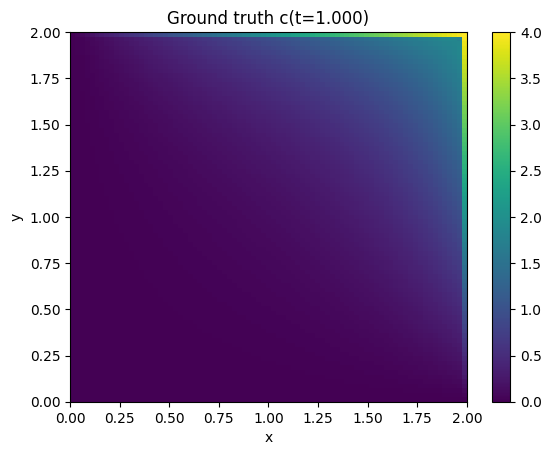

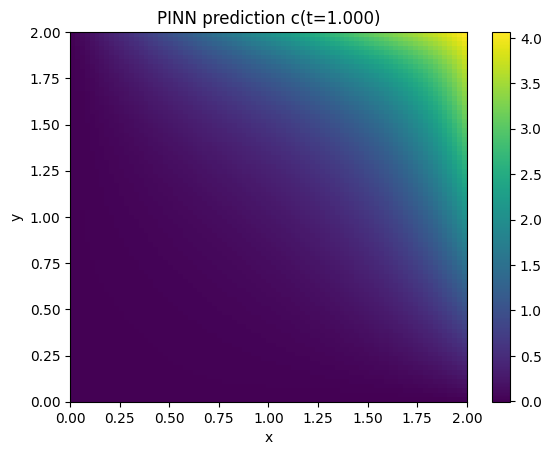

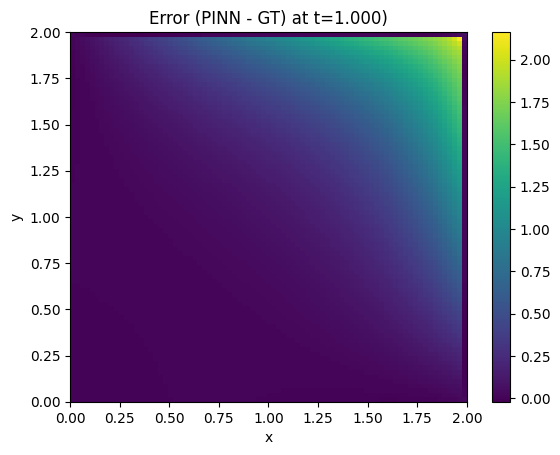

In [11]:
# =========================
# 9) Visualization: GT vs PINN vs Error (heatmaps)
# =========================
def show_heatmap(U, title=''):
    plt.figure()
    plt.imshow(U, origin='lower', extent=[0,p.L,0,p.L], aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('x'); plt.ylabel('y')
    plt.show()

for tt in [0.0, 0.5*p.T, p.T]:
    idx = int(round(tt / p.dt))
    gt = C[idx]
    pred = predict_on_grid(t[idx])
    err = pred - gt

    show_heatmap(gt,   title=f'Ground truth c(t={t[idx]:.3f})')
    show_heatmap(pred, title=f'PINN prediction c(t={t[idx]:.3f})')
    show_heatmap(err,  title=f'Error (PINN - GT) at t={t[idx]:.3f})')
